# Restricted Boltzmann Machine
##### MNIST reconstruction using tensorflow

Import dependencies

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Util functions

function to plot the images after during testing phase

In [2]:
def plot_images(images, title, no_i_x, no_i_y=2):
    fig = plt.figure(figsize=(5, 15))
    fig.canvas.set_window_title(title)
    images = np.array(images).reshape(-1, 28, 28)
    for i in range(no_i_x):
        for j in range(no_i_y):
            ax = fig.add_subplot(no_i_x, no_i_y, no_i_y * i + (j + 1))
            ax.matshow(images[no_i_x * j + i], cmap="gray")
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

            if j == 0 and i == 0:
                ax.set_title("Real")
            elif j == 1 and i == 0:
                ax.set_title("Reconstructed")

load the mnist dataset from tensorflow.examples

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
features_train, features_test, features_valid = \
    mnist.train.images, mnist.test.images, mnist.validation.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Neural Network Model

<br>Hyper-parameters

In [4]:
n_input_layer = features_train.shape[1]
n_hidden_layer = 500

learning_rate = 0.05

n_epoch = 10
batch_size = 100

test_disp = 10  # no of images in plot

Placeholders

In [5]:
X = tf.placeholder(tf.float32, [None, n_input_layer])
W = tf.placeholder(tf.float32, [n_input_layer, n_hidden_layer])
B = tf.placeholder(tf.float32, [n_hidden_layer])
C = tf.placeholder(tf.float32, [n_input_layer])

function to get random sample from input

In [6]:
def get_sample(inp):
    distr = tf.random_uniform(shape=tf.shape(inp))
    sample = tf.nn.relu(tf.sign(inp - distr))
    return sample

#### Model (Training)
using contrastive-divergence-k(k = 1)

x = input <br>
h(x) = P(h|x) = s_h <br>
h(x̄) = P(h) = s_h1 (k=1) <br>
W = W + lr(xᵀh(x) − x̄ᵀh(x̄)) <br>
B = B + lr(h(x) − h(x̄)) <br>
C = C + lr(x − x̄) <br>

In [7]:
# visible-> hidden
p_h = tf.nn.sigmoid(tf.nn.xw_plus_b(X, W, B))
s_h = get_sample(p_h)

# hidden -> visible
p_v = tf.nn.sigmoid(tf.nn.xw_plus_b(s_h, tf.transpose(W), C))  # reconstruction
s_v = get_sample(p_v)

# visible(1) -> hiddden
p_h1 = tf.nn.sigmoid(tf.nn.xw_plus_b(s_v, W, B))
s_h1 = get_sample(p_h1)

# error - just for measuring correctness of reconstructed image
error = tf.losses.mean_squared_error(labels=X, predictions=p_v)

# positive and negative phase gradients
positive_phase = tf.matmul(tf.transpose(X), s_h)
negative_phase = tf.matmul(tf.transpose(s_v), s_h1)

contr_div = (positive_phase - negative_phase) / tf.to_float(tf.shape(X)[0])

# calculate delta for var
change_w = contr_div
change_b = tf.reduce_mean((s_h - s_h1), axis=0)
change_c = tf.reduce_mean((X - s_v), axis=0)

# Adjust Weights
new_W = W + learning_rate * change_w
new_B = B + learning_rate * change_b
new_C = C + learning_rate * change_c

### Train Neural Network

Initialize random  Weights and biases

In [8]:
w = np.random.uniform(0.1, size=(n_input_layer, n_hidden_layer))
b = np.random.uniform(0.1, size=n_hidden_layer)
c = np.random.uniform(0.1, size=n_input_layer)

split into batches

In [9]:
n_batch = features_train.shape[0] // batch_size
batched_data = np.split(features_train, n_batch)

#### Start session

In [10]:
disp_imgs = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    print("*********** Train ***********")

    # Epoch-training
    for epoch in range(n_epoch):
        err = []

        # Batch training
        for b_idx in range(n_batch):
            e, w, b, c = sess.run([error, new_W, new_B, new_C], feed_dict={
                X: batched_data[b_idx], W: w, B: b, C: c})

            err.append(e)
        
        val_e = error.eval({X: features_valid, W: w, B: b, C: c})

        print("Epoch: %d, Training-error: %.8f, Validation-error: %.8f" %
              (epoch, sum(err) / len(err), val_e))
    
    print("*********** Test ***********")

    # Test-Reconstruction
    test_e, reconstd_image = sess.run([error, p_v], feed_dict={
                X: features_test, W: w, B: b, C: c})
    
    print("Test-error: %.8f" % test_e)
    
    disp_imgs.extend(features_test[:test_disp])
    disp_imgs.extend(reconstd_image[:test_disp])

*********** Train ***********
Epoch: 0, Training-error: 0.04644489, Validation-error: 0.02066885
Epoch: 1, Training-error: 0.01913762, Validation-error: 0.01762982
Epoch: 2, Training-error: 0.01702874, Validation-error: 0.01610900
Epoch: 3, Training-error: 0.01586430, Validation-error: 0.01527168
Epoch: 4, Training-error: 0.01507473, Validation-error: 0.01459762
Epoch: 5, Training-error: 0.01450215, Validation-error: 0.01412933
Epoch: 6, Training-error: 0.01405964, Validation-error: 0.01375704
Epoch: 7, Training-error: 0.01367655, Validation-error: 0.01342796
Epoch: 8, Training-error: 0.01338743, Validation-error: 0.01311545
Epoch: 9, Training-error: 0.01310958, Validation-error: 0.01285918
*********** Test ***********
Test-error: 0.01286180


#### plot output

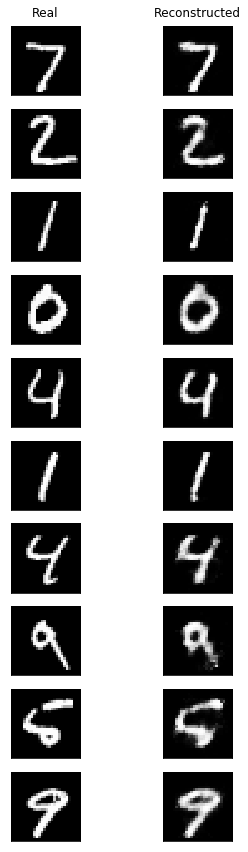

In [11]:
plot_images(disp_imgs, "Restricted Boltzmann Machine", test_disp)
plt.show()